# **Μερική Διαφορική Εξίσωση (μη-γραμμική) 1D R. Camassa & D. D. Holm (1993)**

### **Προσεγγίζουμε την ΜΔΕ C-H:**

$$
u_{t} - u_{xxt} + 3\ u\ u_{x} = 2\ u_{x}\ u_{xx} + u\ u_{xxx}
$$

**με**

$$ L = 40 $$

$$x \in \left[-\frac{L}{2},\frac{L}{2}\right]=[-20,20]$$

$$t \in [0,T]=[0,5]$$

---

### **Αρχική συνθήκη:**

$$
u(x,0) = c\ e^{-|x|}
$$

**με**

$$ c = 1 $$
$$ x_0 = 0 $$

$$Για\ c>0\ έχουμε\ u>0 $$
$$Για\ c<0\ έχουμε\ u<0 $$

---

### **Συνοριακές συνθήκες: (Περιοδικές)**

$$ u(-L,t) = u(L,t) $$
$$ u_{x}(-L,t) = u_{x}(L,t) $$


In [33]:
import torch #βασικό πακέτο PyTorch
import torch.nn as nn #έτοιμες συναρτήσεις για νν
import torch.nn.functional as f #συναρτήσεις ενεργοποίησης
import torch.optim as optim #βελτιστοποιητές
import numpy as np #βιβλιοθήκη αριθμητικών υπολογισμών
from time import time #μέτρηση χρόνου
import gc #για καθαρισμό cpu
import platform #για το τι συσκευή cpu χρησιμοποιώ


use_cuda = input("Να κεράσω CUDA; (ναι/οχι): ").strip().lower()

if use_cuda == "ναι":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

print("Χρήση συσκευής:", device)
print(torch.__version__)

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print("Κερασμένη η CUDA!")
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  torch.cuda.empty_cache() # άδειασμα gpu
else:
  print("Μας τελείωσε η CUDA...")
  print(platform.uname())
  gc.collect() # άδειασμα cpu

#Ζέσταμα GPU για να μην πετάει warning
if device.type == "cuda":
    torch.cuda.init()
    torch.cuda.empty_cache()
    torch.randn(8, 8, device=device) #warm-up cuBLAS

Να κεράσω CUDA; (ναι/οχι): l
Χρήση συσκευής: cpu
2.9.0+cpu
False
Μας τελείωσε η CUDA...
uname_result(system='Linux', node='bb7592a72644', release='6.6.105+', version='#1 SMP Thu Oct  2 10:42:05 UTC 2025', machine='x86_64')


In [34]:
#ορισμός ακρίβειας
dtype = torch.float32

#Σταθερές
pi = torch.tensor(np.pi, dtype=dtype, device=device) #π
wave_speed = torch.tensor(1, dtype=dtype, device=device) #ταχύτητα διάδοσης c
L = 20 #πλάτος χώρου
L_min = torch.tensor(-L/2, dtype=dtype, device=device) #πλάτος χώρου ελάχιστο
L_max = torch.tensor(L/2, dtype=dtype, device=device) #πλάτος χώρου μεγιστο
T_max = torch.tensor(5, dtype=dtype, device=device) #χρόνος

#Αρχικές Συνθήκες
def fun_u_0(t,x):
  return wave_speed * torch.exp( -torch.abs( wave_speed * x ) )

#def fun_u_0(t, x):
#    K = 3
#    u_sum = torch.zeros_like(x)
#    for k in range(-K, K+1):
#        u_sum = u_sum + wave_speed * torch.exp(-torch.abs(wave_speed * (x - k * L)))
#    return u_sum

#Συνοριακές Συνθήκες
def fun_u_b_left(t,x):
  #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
  #Ενσωματώνονται στο training loop και loss
  return None

def fun_u_b_right(t,x):
  #Στις περιοδικές δεν έχω αντίστοιχη συνάρτηση
  #Ενσωματώνονται στο training loop και loss
  return None

#ΜΔΕ Εξίσωση Κύματος C-H
def fun_r(u_t, u_xxt, u, u_x, u_xx, u_xxx):
  return u_t - u_xxt + 3 * u * u_x - 2 * u_x * u_xx - u * u_xxx

In [35]:
#Αριθμός σημείων
N_0 = 400 #πλήθος αρχικής συνθήκης u(x,0) και u_x(x,0)
N_b = 500 #πλήθος συνοριακών συνθηκών u(0, t) και u(1,t)
N_r = 2000 #πλήθος στο εσωτερικό του πεδίου εκπαίδευσης της ΜΔΕ

#Συνοριακές τιμές
tmin = torch.tensor(0, dtype=dtype, device=device)
tmax = T_max
xmin = L_min
xmax = L_max

In [36]:
print(f'Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:\n')
print(f'[tmin,tmax] x [xmin,xmax]')
print(f'[{tmin}, {tmax.item()}] x [{xmin}, {xmax.item()}]\n')

Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:

[tmin,tmax] x [xmin,xmax]
[0.0, 5.0] x [-10.0, 10.0]



In [37]:
#Κάτω όριο
lb = torch.tensor([tmin, xmin], dtype=dtype, device=device)
#Πάνω όριο
ub = torch.tensor([tmax, xmax], dtype=dtype, device=device)

In [38]:
print(f'lb:', lb.device)
print(f'ub:', ub.device)

lb: cpu
ub: cpu


In [39]:
#Σταθεροποίηση γεννήτριας τυχαίων αριθμών
torch.manual_seed(67)

In [40]:
#Δημιουργία σημείων αρχικών συνθηκών


#στήλη με την αρχική τιμή του χρόνου
###t_0 = torch.ones((N_0,1), dtype=dtype, requires_grad=True, device=device)*lb[0]
t_0 = torch.ones((N_0,1), dtype=dtype, device=device)*lb[0]

#στήλη με τυχαίους στο διάστημα [xmin,xmax]
###x_0 = torch.rand((N_0,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]
x_0 = torch.rand((N_0,1), dtype=dtype, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σε tensor (N0,2) ##δύο στήλες t0,x0
X_0 = torch.concat([t_0, x_0], dim=1)

In [41]:
print(f't_0: ',t_0.shape)
print(f'x_0: ',x_0.shape)
print(f'X_0: ',X_0.shape)
print(f't_0: ',t_0.device)
print(f'x_0: ',x_0.device)
print(f'X_0: ',X_0.device)

t_0:  torch.Size([400, 1])
x_0:  torch.Size([400, 1])
X_0:  torch.Size([400, 2])
t_0:  cpu
x_0:  cpu
X_0:  cpu


In [42]:
#Υπολογισμός αρχικών συνθηκών
u_0 = fun_u_0(t_0, x_0)

In [43]:
print(f'u_0: ',u_0.shape)
print(f'u_0: ',u_0.device)

u_0:  torch.Size([400, 1])
u_0:  cpu


In [44]:
#Δημιουργία σημείων Συνοριακών Συνθηκών


#στήλη με τυχαίους στο διάστημα [tmin, tmax]
t_b = torch.rand((N_b,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]
###t_b = torch.rand((N_b,1), dtype=dtype, device=device)*(ub[0]-lb[0]) + lb[0]

#στήλη με N_b στοιχεία για το xmin σύνορο (αριστερά)
x_b_left = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*lb[1]
###x_b_left = torch.ones((N_b, 1), dtype=dtype, device=device)*lb[1]

#στήλη με N_b στοιχεία για το xmax σύνορο (δεξιά)
x_b_right = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*ub[1]
###x_b_right = torch.ones((N_b, 1), dtype=dtype, device=device)*ub[1]

#Συνδιασμός σε tensor (N_b,2)
X_b = torch.concat([t_b, x_b_left, x_b_right], dim=1)

In [45]:
print(f't_b:       ',t_b.shape)
print(f'x_b_left:  ',x_b_left.shape)
print(f'x_b_right: ',x_b_right.shape)
print(f'X_b:       ',X_b.shape)
print(f't_b:       ',t_b.device)
print(f'x_b_left:  ',x_b_left.device)
print(f'x_b_right: ',x_b_right.device)
print(f'X_b:       ',X_b.device)

t_b:        torch.Size([500, 1])
x_b_left:   torch.Size([500, 1])
x_b_right:  torch.Size([500, 1])
X_b:        torch.Size([500, 3])
t_b:        cpu
x_b_left:   cpu
x_b_right:  cpu
X_b:        cpu


In [46]:
#Υπολογισμός Συνοριακών Συνθηκών

#Αυτό το κομμάτι κώδικα στις περιοδικές δεν χρειάζεται.
#Δεν έχουμε να υπολογίσουμε κάτι, θέλουμε απλά να είναι ίσες.

In [47]:
#Τυχαία σημεία λύσης

#Δημιουργία τυχαίων τιμών στο χρόνο [tmin, tmax]
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#Δημιουργία τυχαίων τιμών στο χώρο [xmin, xmax]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σημείων σε tensor (N_r,2)
X_r = torch.concat([t_r, x_r], dim=1)

In [48]:
print(f't_r: ',t_r.shape)
print(f'x_r: ',x_r.shape)
print(f'X_r: ',X_r.shape)
print(f't_r: ',t_r.device)
print(f'x_r: ',x_r.device)
print(f'X_r: ',X_r.device)

t_r:  torch.Size([2000, 1])
x_r:  torch.Size([2000, 1])
X_r:  torch.Size([2000, 2])
t_r:  cpu
x_r:  cpu
X_r:  cpu


In [49]:
#λίστες

#(Ν_0,2) αρχικά σημεία, (Ν_b,3) συνοριακά σημεία
X_data = [X_0, X_b]

#(Ν_0,2) αρχικές τιμές, (Ν_b,2) συνοριακές τιμές
u_data = [u_0]

In [50]:
print(f'X_data[0]==X_0: ',X_data[0].shape)
print(f'X_data[1]==X_b: ',X_data[1].shape)
print(f'u_data[0]==u_0: ',u_data[0].shape)
print(f'X_data[0]==X_0: ',X_data[0].device)
print(f'X_data[1]==X_b: ',X_data[1].device)
print(f'u_data[0]==u_0: ',u_data[0].device)

X_data[0]==X_0:  torch.Size([400, 2])
X_data[1]==X_b:  torch.Size([500, 3])
u_data[0]==u_0:  torch.Size([400, 1])
X_data[0]==X_0:  cpu
X_data[1]==X_b:  cpu
u_data[0]==u_0:  cpu


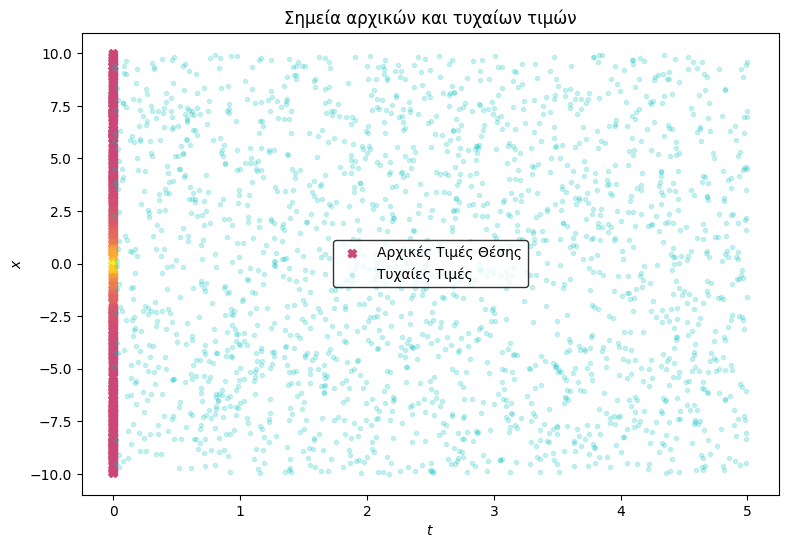

In [51]:
import matplotlib.pyplot as plt #βιβλιοθήκη γραφήματα

fig = plt.figure(figsize=(9,6)) #καμβάς 9x6 ίντσες
color = 'plasma' #επιλογή χρώματος γραφίματος

#σημεία αρχικής συνθήκης
plt.scatter(t_0.cpu().detach(), x_0.cpu().detach(), c=u_0[:,[0]].cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Αρχικές Τιμές Θέσης')

#σημεία τυχαία
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(loc='center').get_frame().set_edgecolor('black')
plt.title('Σημεία αρχικών και τυχαίων τιμών');
plt.show()

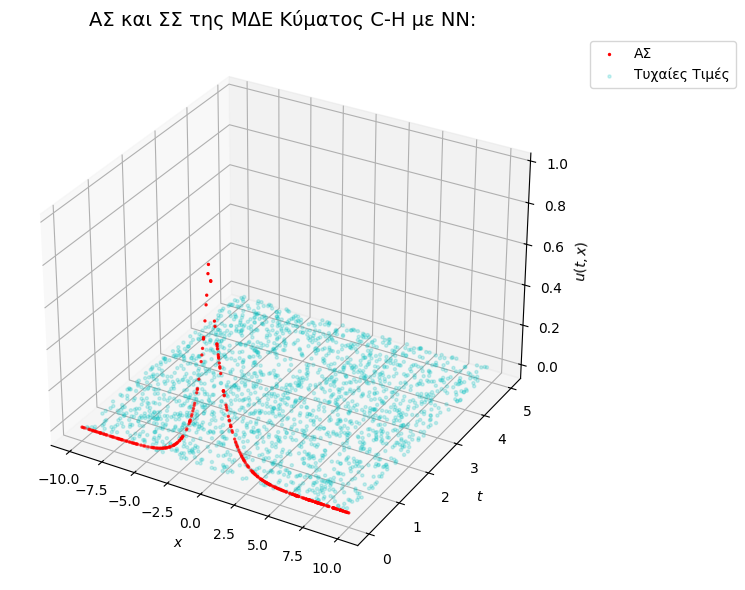

Στο t=Τ έχουμε min U_0 = 0.000, max U_0 = 0.966


In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u_0.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#σημεία τυχαία
ax.scatter(x_r.cpu().detach(), t_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και ΣΣ της ΜΔΕ Κύματος C-H με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u_0.min().item()
U0_max = u_0.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

In [53]:
#Δημιουργία ΝΝ

class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        #Το input layer συνδέεται στο 1ο layer (με 20 νευρώνες)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        #Τα layers από το 1ο μέχρι το 8ο
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        #Το output layer δίνει πραγματική τιμή
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        #Αρχικοποίηση βαρών
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            #αποτρέπει τα πολύ μεγάλα και πολύ μικρά βάρη
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        #Μετασχηματιμσός του x για να βρίσκεται στο [lb[1], ub[1]]=[xmin,xmax]=[-1,1] για ταχύτερη επκπαίδευση με την tanh
        x = 2.0*(x - lb)/(ub - lb) - 1.0

        #Το input layer
        x = torch.tanh(self.input_layer(x))
        #1ο με 8ο hidden layer
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        #Το output layer
        x = self.output_layer(x)
        return x

In [54]:
#Υπολογισμός Απώλειας

mse_loss = nn.MSELoss() #Μέσο Τετραγωνικό Σφάλμα

def compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag):

    ##Απώλεια ΜΔΕ
    #Σπάσιμο στηλών t,x για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    t = X_r[:,0:1]#.detach().requires_grad_(True)
    x = X_r[:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση ΜΔΕ μοντέλου
    u = model(torch.concat([t,x],dim=1))

    #Υπολογισμός Μερικών Παραγώγων
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_xxt = torch.autograd.grad(u_xx, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]

    #Υπολογισμός του απώλειας της ΜΔΕ
    l_u = torch.mean(torch.square(fun_r(u_t, u_xxt, u, u_x, u_xx, u_xxx)))


    ##Απώλεια αρχικής συνθήκης
    #Σπάσιμο του t0,x0 για να υπολογιστεί ξεχωριστά η μερική παράγωγος
    t0 = X_data[0][:,0:1]#.clone().detach().requires_grad_(True)
    x0 = X_data[0][:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου για την θέση και ταχύτητα
    u0 = model(torch.concat([t0, x0],dim=1))

    #Υπολογισμός απώλειας θέσης και ταχύτητας
    l_0 = torch.mean(torch.square(u_data[0][:,0:1]-u0))


    #Υπολογισμός απώλειας συνοριακών συνθηκών
    #Σπάσιμο στηλών t,xl,xr για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    tb = X_data[1][:,0:1]#.clone().detach().requires_grad_(True)
    xbl = X_data[1][:,1:2]#.detach().requires_grad_(True)
    xbr = X_data[1][:,2:3]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου Αριστερά
    ubl = model(torch.concat([tb, xbl],dim=1))
    ubl_x = torch.autograd.grad(ubl, xbl, torch.ones_like(ubl), create_graph=True)[0]

    #Εκτίμηση μοντέλου Δεξιά
    ubr = model(torch.concat([tb, xbr],dim=1))
    ubr_x = torch.autograd.grad(ubr, xbr, torch.ones_like(ubr), create_graph=True)[0]

    #Υπολογισμός απώλειας συνοριακών συνθηκών
    l_lr = mse_loss(ubl, ubr)
    l_lr_x = mse_loss(ubl_x, ubr_x)
    l_b = l_lr + l_lr_x

    #Προσαρμογή Βαρών κάθε loss
    w_u = 1
    w_b = 1
    w_0 = 1

    #Συνολική απώλεια
    loss = w_u * l_u + w_b * l_b + w_0 * l_0

    if (epochs % 100 == 0) and (verbose_flag != -1):
      print(f'Epoch {epochs:05d}: l_u = {l_u:10.8e}, l_b = {l_b:10.8e} l_0 = {l_0:10.8e}, loss = {loss:10.8e}')

    return loss

In [55]:
model = NeuralNetwork().to(device)

#Σταθερά learning rate
lr_schedule = [1e-3, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 100:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

#Adam βελτιστοποιητής
optimizer = torch.optim.Adam(model.parameters(), lr=lr_schedule[0])

In [56]:
#Αριθμός εποχών
epochs=0
epoch = 2000
#Λίστα απώλειας κάθε εποχής
losses = []
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

for i in range(epoch):

    #Ενημέρωση της σταθεράς learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    #Μηδενισμός των παραγώγων του βελτιστοποιητή πριν το backpropagation
    optimizer.zero_grad()

    #Υπολογισμός σφάλματος
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=1)

    #Υπολογισμός των παραγώγων τρέχουσας εποχής
    loss.backward(retain_graph=True)

    #Ενημέρωση βαρών επόμενης εποχής
    optimizer.step()

    #Αποθήκευση του σφάλματος κάθε εποχής
    losses.append(loss.item())

    #Για την εκτύπωση του loss
    epochs = epochs + 1

    #Εφαρμογή του early stopping
    if loss.item() < 1e-5:
       break

#Εμφάνιση χρόνου εκτέλεσης του μοντέλου
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Εκπαίδευσης Μοντέλου: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')
print(f'\nEpochs: {epochs}, loss = {losses[epochs-1]:10.8e}')


Epoch 00000: l_u = 8.96049605e-05, l_b = 1.02385050e-02 l_0 = 8.92595574e-02, loss = 9.95876640e-02
Epoch 00100: l_u = 6.14918710e-04, l_b = 1.39541211e-04 l_0 = 1.59125831e-02, loss = 1.66670438e-02
Epoch 00200: l_u = 4.72479966e-04, l_b = 6.53782336e-05 l_0 = 9.36133415e-03, loss = 9.89919249e-03
Epoch 00300: l_u = 7.39248178e-04, l_b = 4.71081439e-05 l_0 = 4.75856662e-03, loss = 5.54492278e-03
Epoch 00400: l_u = 9.57364915e-04, l_b = 5.50076584e-05 l_0 = 2.89867190e-03, loss = 3.91104445e-03
Epoch 00500: l_u = 9.27211309e-04, l_b = 5.71400888e-05 l_0 = 2.12308369e-03, loss = 3.10743507e-03
Epoch 00600: l_u = 8.59617954e-04, l_b = 4.72160245e-05 l_0 = 1.64785341e-03, loss = 2.55468744e-03
Epoch 00700: l_u = 7.87960074e-04, l_b = 3.97760232e-05 l_0 = 1.30710436e-03, loss = 2.13484047e-03
Epoch 00800: l_u = 6.79085322e-04, l_b = 3.56882920e-05 l_0 = 1.05770899e-03, loss = 1.77248265e-03
Epoch 00900: l_u = 5.82942623e-04, l_b = 3.11551994e-05 l_0 = 8.82227032e-04, loss = 1.49632478e-03


In [57]:
# Fine-tuning με L-BFGS
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

lbfgs_counter = 0  #μετρητής βημάτων LBFGS

optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),    #μεταβολή των βαρών του μοντέλου
                                    max_iter=500,          #μέγιστος αριθμός εσωτερικών βημάτων
                                    tolerance_grad=1e-7,   #έξοδος όταν η μέση κλίση είναι μικρότερη από
                                    tolerance_change=1e-9, #έξοδος όταν τα βάρη είναι μικρότερα από
                                    history_size=50,       #πόσα προηγούμενα βήματα να θυμάται για την εκτίμηση της Hessian
                                    line_search_fn="strong_wolfe") #για σταθερή σύγκλιση, αποφυγεί πολύ μικρών/μεγάλων βημάτων

def closure():
    optimizer_lbfgs.zero_grad() #μηδενισμός προηγούμενων gradients
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=-1) #υπολογισμός απώλειας
    loss.backward(retain_graph=True) #υπολογισμός gradients
    global lbfgs_counter #για να την πάρει από έξω
    lbfgs_counter = lbfgs_counter + 1 #μετρητής βημάτων LBFGS
    return loss

#Μία κλήση LBFGS (κάνει εσωτερικά 500 αλληλεπιδράσεις)
optimizer_lbfgs.step(closure)

#Τελική αξιολόγηση μετά το LBFGS
loss_lbfgs = compute_loss(model, X_r, X_data, u_data, 0, verbose_flag=-1)

print(f"LBFGS Επανάληψη {lbfgs_counter}")
print(f"LBFGS Σφάλμα {loss_lbfgs.item():10.8e}")
print(f"LBFGS βελτίωση: Από {losses[-1]:10.8e} σε {loss_lbfgs.item():10.8e}")
print(f"Διαφορά LBFGS με Adam: {(loss_lbfgs.item() - losses[-1]):+10.8e}")

#Εμφάνιση χρόνου εκτέλεσης του LBFGS
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Βελτιστοποίησης με LBFGS: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')


LBFGS Επανάληψη 313
LBFGS Σφάλμα 7.93153595e-05
LBFGS βελτίωση: Από 4.10788314e-04 σε 7.93153595e-05
Διαφορά LBFGS με Adam: -3.31472955e-04

Χρόνος Βελτιστοποίησης με LBFGS: 0 μέρες, 0 ώρες, 0 λεπτά, 36 δευτερόλεπτα


In [58]:
#input(f"Να συνεχίσω το προγραμμα' ; (ναι/οχι): ").strip().lower()

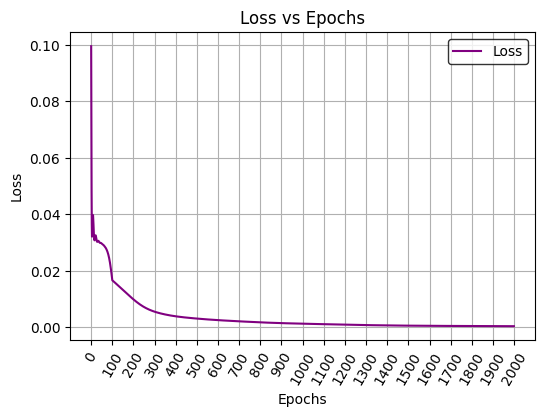

In [59]:
#Απώλεια κάθε εποχής
fig = plt.figure(figsize=(6,4))

plt.plot(range(epochs), losses, label='Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(loc='upper right').get_frame().set_edgecolor('black')
plt.xticks(range(0, epoch+1, 100), rotation=60)
plt.grid(True)
plt.show()

u0_m:  torch.Size([400, 1])
ubl_m:  torch.Size([500, 1])
ubr_m:  torch.Size([500, 1])


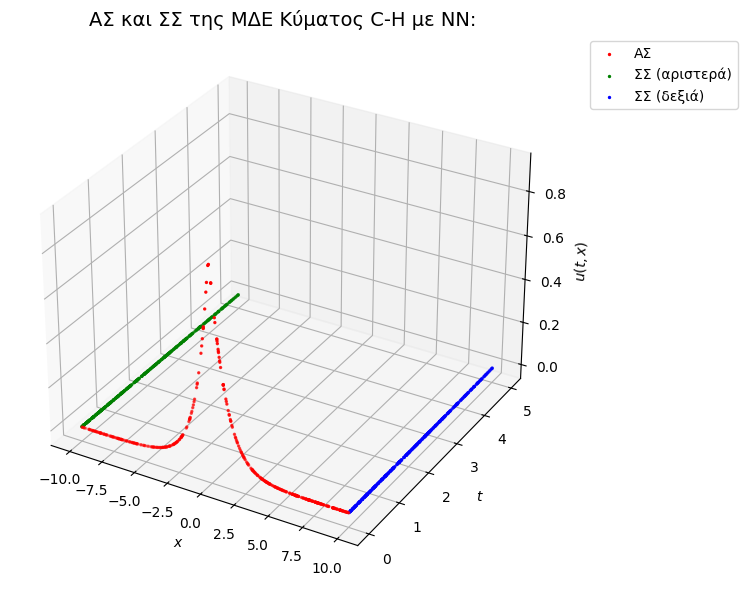

Στο t=Τ έχουμε min U_0 = -0.001, max U_0 = 0.904


In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Τελική εκτίμηση μοντέλου Αρχικής Συνθήκης
u0_m = model(torch.concat([t_0, x_0],dim=1))
print(f'u0_m: ',u0_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Αριστερά
ubl_m = model(torch.concat([t_b, x_b_left],dim=1))
print(f'ubl_m: ',ubl_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Δεξιά
ubr_m = model(torch.concat([t_b, x_b_right],dim=1))
print(f'ubr_m: ',ubr_m.shape)

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u0_m.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#Συνοριακή Συνθήκη (Αριστερά)
ax.scatter(x_b_left.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubl_m.detach().cpu().numpy(), color='g', label='ΣΣ (αριστερά)', s=2);

#Συνοριακή Συνθήκη (Δεξιά)
ax.scatter(x_b_right.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubr_m.detach().cpu().numpy(), color='b', label='ΣΣ (δεξιά)', s=2);


ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και ΣΣ της ΜΔΕ Κύματος C-H με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u0_m.min().item()
U0_max = u0_m.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

Για t=[0,T] έχουμε min U = -0.001, max U = 0.905
Στο t=Τ έχουμε min U = 0.000, max U = 0.869


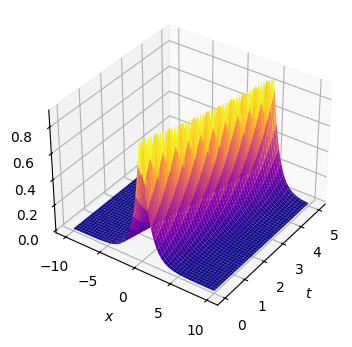

In [61]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

tmin = tmin.cpu().item()
tmax = tmax.cpu().item()
xmin = xmin.cpu().item()
xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(6,4))
#fig.suptitle('Μοντελοποίηση ΜΔΕ Περιοδικού Κύματος C-H με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')

ax1.invert_xaxis()


print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

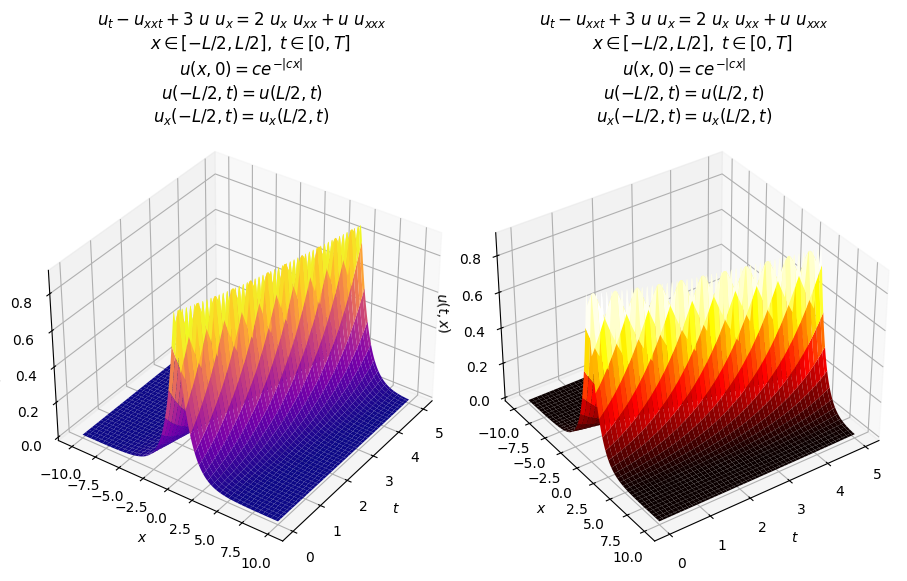

Για t=[0,T] έχουμε min U = -0.001, max U = 0.905
Στο t=T έχουμε min U = 0.000, max U = 0.869


In [62]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(9,6))
#fig.suptitle('Μοντελοποίηση ΜΔΕ Κύματος C-H με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,215)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')
ax1.set_title(r'$u_{t} - u_{xxt} + 3\ u\ u_{x} = 2\ u_{x}\ u_{xx} + u\ u_{xxx}$' '\n'
              r'$\quad x \in [-L/2, L/2],\ t \in [0,T]$' '\n'
              r'$u(x, 0) = c e^{-|c x|}$' '\n'
              r'$u(-L/2, t) = u(L/2, t)$' '\n'
              r'$u_{x}(-L/2, t) = u_{x}(L/2, t)$',
              fontsize=12);
ax1.invert_yaxis()


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T, X, U, cmap='hot');
ax2.view_init(35,235)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_zlabel('$u(t,x)$')
ax2.set_title(r'$u_{t} - u_{xxt} + 3\ u\ u_{x} = 2\ u_{x}\ u_{xx} + u\ u_{xxx}$' '\n'
              r'$\quad x \in [-L/2, L/2],\ t \in [0,T]$' '\n'
              r'$u(x, 0) = c e^{-|c x|}$' '\n'
              r'$u(-L/2, t) = u(L/2, t)$' '\n'
              r'$u_{x}(-L/2, t) = u_{x}(L/2, t)$',
              fontsize=12);
ax2.invert_yaxis()

# Εμφάνιση του αποτελέσματος
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=T έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')


In [63]:
import plotly.graph_objects as go

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#τίτλος
lines = (
    r'<b>Μοντελοποίηση ΜΔΕ Κύματος C-H με NN<b>',
    r'$u_{t} - u_{xxt} + 3\ u\ u_{x} = 2\ u_{x}\ u_{xx} + u\ u_{xxx}$',
    r'$\quad x \in [-L/2, L/2],\ t \in [0,T]$',
    r'$u(x, 0) = c e^{-|c x|}$',
    r'$u(-L/2, t) = u(L/2, t)$',
    r'$u_{x}(-L/2, t) = u_{x}(L/2, t)$'
)

#δημιουργία γραμμών τίτλου
annotations = []
x_pos = 0.05
start_y = 1.05
dy = -0.055

for i, line in enumerate(lines):
    annotations.append(
        dict(
          text=line,
          x=x_pos,
          y=start_y + i * dy,
          xref='paper',
          yref='paper',
          showarrow=False,
          font=dict(size=13 if i > 0 else 16, family="Arial"),
          align='center'
        )
    )

#αποκοπή των δεκαδικών ψηφίων από μιν μαξ τιμές για εμφάνιση
def truncation(x, decimals):
    factor = 10 ** decimals
    return torch.trunc(x * factor) / factor

U_tensor = torch.tensor(U)

min_U = truncation(torch.min(U_tensor), 1).item()
max_U = truncation(torch.max(U_tensor), 1).item()

#δημιουργία tickvals στη ράβδο
tickvals = [
    min_U + 0.001,
    truncation(torch.tensor((min_U + max_U)/2), 3).item(),
    max_U - 0.001
]



#δημιουργία 3D γραφήματος
fig = go.Figure(
    data=[
        go.Surface(
            x=tspace,
            y=xspace,
            z=U,
            colorscale='jet',
            colorbar=dict(
                title=dict(text='u(x,t)', side='top', font=dict(size=12)),
                tickvals = tickvals,
                x=0.88,         # αριστερά/δεξιά
                y=0.48,         # πάνω/κάτω
                len=0.9,        # πόσο "μακρύ" κάθετα
                thickness=20,   # πόσο "παχύ" οριζόντια
                tickfont=dict(size=10)
                )
            )
        ]
    )

fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),
    scene=dict(
        xaxis=dict(title='t', autorange='reversed'),  #αντιστροφή άξονα x
        yaxis_title='x',
        zaxis_title='u(t,x)'
    ),
    annotations=annotations
        )

fig.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=T έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

Output hidden; open in https://colab.research.google.com to view.

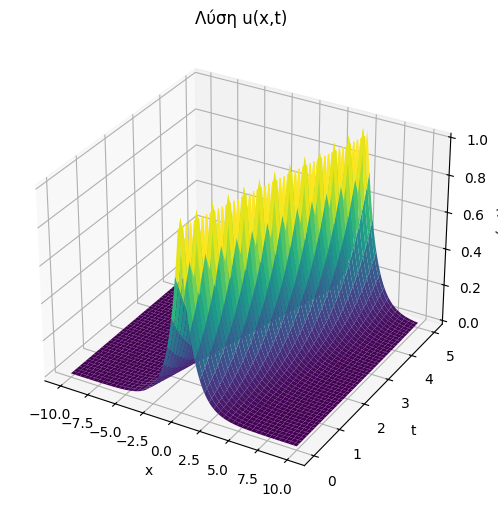

Για t=[0,T] έχουμε min Uanal = 0.000, max Uanal = 1.000
Στο t=Τ έχουμε min Uanal = 0.000, max Uanal = 0.007


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dtype = np.float32
c = wave_speed.item()

#σημεία
x = np.linspace(xmin, xmax, 200)
t = np.linspace(tmin, tmax, 200)
X, T = np.meshgrid(x, t)

#λύση κύματος
U_anal = c * np.exp( - np.abs( X - c * T))

#γράφημα
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_anal, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Λύση u(x,t)')

plt.show()

print(f'Για t=[0,T] έχουμε min Uanal = {U_anal.min():.3f}, max Uanal = {U_anal.max():.3f}')

# Τελικό χρονικό βήμα
Uanal_final = U_anal[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
Uanal_min = Uanal_final.min()
Uanal_max = Uanal_final.max()
print(f'Στο t=Τ έχουμε min Uanal = {Uanal_min:.3f}, max Uanal = {Uanal_max:.3f}')

###Διαφορές προσεγγίσεων:

*1) Αναλυτική - Pinn*

*2) Αναλυτική - RK4*

*3) Pinn - RK4*